# Contrasting by Patient Augmented Electrocardiograms (CAPE)
This is a small demonstrating the out-of-distribution (OOD) performance for an MLP trained on ECG features generated using CAPE model with and without in-distribution-batch (IDB) pretrained on BCSV dataset. The MLP model is trained on labels for BIDMC dataset and tested for open source ECG datasets of CODE15 (https://zenodo.org/records/4916206), and PTBXL (https://physionet.org/content/ptb-xl/1.0.1/) datasets. The test shows that for the CODE15 there is a significant deterioration in the performance that is mitigated by incorporating IDB.

Importing required libraries

In [23]:
import sys
import h5py
import utils as u
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model, Model
from sklearn.metrics import *
import time
import pandas as pd
import random
import numpy as np
import math
random.seed(10)
import glob
import sklearn


Testing the MLP trained on BIDMC for the external datasets

In [24]:
class MLP_test:
    def __init__(self):
        """
        Testing for multiple datasets.
        """
        self.datapath = 'data/ECGdata/'
        self.datasets = ['code15', 'ptb']
        featnames = {}
        featnames['code15'] = 'CAPE_feats_BTCSV_CODE15.h5'
        featnames['ptb'] = 'CAPE_feats_BTCSV_PTBXL.h5'
        self.featnames = featnames
        datasize = {}
        datasize['code15'] = 0
        datasize['ptb'] = 0
        self.datasize = datasize
        self.model_path =os.path.join('MLP_models', 'MLP_CAPE_BTCSV')
        self.outdir = 'results'
        self.name = f'MLP_code15_age_sex_runs10_seed10_CAPE_BTCSV'
        self.ntest = 10000
        self.target_labels = ['age', 'sex']
        self.r_loss = 'mse'
        self.c_loss = 'binary_crossentropy'
        self.r_activation = 'sigmoid' 
        self.c_activation = 'sigmoid'
        self.r_metrics = ['mae', 'r2_score']
        self.c_metrics = ['AUC', 'f1_score']
        self.r_monitor = 'val_mae'
        self.c_monitor = 'val_auc'
        self.seed = 10
        np.random.seed(self.seed)
        self.result_dir = os.path.join(self.outdir, self.name)
        u.safe_mkdir(self.result_dir)

        
        data_info = u.get_data_info()
        for key in data_info:
            data_info[key]['code15']= data_info[key]['code']
        data_info['sex']['code15'] = 'is_male'
        self.data_info = data_info
        training_type = {}
        for target in self.target_labels:
            training_type[target] = 'regression' if 'age' in target else 'classification'
        self.training_type = training_type
        
        task = {}
        task['classification'] = {}
        task['classification']['metrics'] = self.c_metrics
        task['classification']['loss'] = self.c_loss
        task['classification']['activation'] = self.c_activation
        task['classification']['monitor'] = self.c_monitor
        task['regression'] = {}
        task['regression']['metrics'] = self.r_metrics
        task['regression']['loss'] = self.r_loss
        task['regression']['activation'] = self.r_activation
        task['regression']['monitor'] = self.r_monitor
        self.task = task
        
        tparams = {}
        tparams['age'] = {}
        tparams['age']['lr'] =0.0001
        tparams['age']['epochs'] = 100
        tparams['age']['hidden'] = [256, 128]
        tparams['age']['use_weights'] = 0
        tparams['sex'] = {}
        tparams['sex']['lr'] =0.0001
        tparams['sex']['epochs'] = 100
        tparams['sex']['hidden'] = [256, 256]
        tparams['sex']['use_weights'] = 1
        self.tparams =tparams
        
        self.scores = {}
        self.labels_filename = 'ecg_labels.csv'
        
    def myshuffle(self, arr):    
        np.random.shuffle(arr)
        return arr
    
    def df_describe(self, df, save=1):
        df1 = df.describe()
        df2 = pd.DataFrame(df.sem()).T
        df2.index=['SE']
        df_stats = pd.concat([df1, df2], axis=0)
        if save: df_stats.to_csv(os.path.join(self.result_dir, 'res_stats.csv'))
        return df_stats
    
    def get_stats(self, score_names = ['AUC', 'mae_years']):
        scores = []
        labels_auc =[]
        labels_mae =[]

        file_names = glob.glob(os.path.join(self.result_dir, f'score_*.csv'))
        df = pd.DataFrame()  
        for j, file_name in enumerate(file_names):
            score = pd.read_csv(file_name)
            label = os.path.relpath(file_name, self.result_dir)
            dlabel = label.split('_')[1]
            dataset = label.split('_')[2].replace('.csv', '')
            for score_name in score_names:
                if score_name in score:           
                  if 'age' in dlabel: 
                    column_name = f'{dataset} {dlabel}'
                    df[column_name] =score[score_name]
                  else:
                    column_name = f'{dataset} {dlabel}'
                    df[column_name] = score[score_name]
                  if score_name == 'AUC'and column_name not in labels_auc:  labels_auc.append(column_name)
                  if score_name == 'mae_years'and column_name not in labels_mae:  labels_mae.append(column_name)
        #print(labels_auc, labels_mae)
        df['mean AUC'] = df[labels_auc].mean(numeric_only=True, axis=1)
        df['mean MAE'] = df[labels_mae].mean(numeric_only=True, axis=1)
        return df
    
    def get_pred(self, label):
        y = []
        y_pred = []
        file_names = glob.glob(os.path.join(self.result_dir, f'predictions_{label}_*.csv'))
        df = pd.DataFrame()  
        for j, file_name in enumerate(file_names):
            df = pd.read_csv(file_name)
            label = os.path.relpath(file_name, self.result_dir)
            dlabel = label.split('_')[1]
            dataset = label.split('_')[2].replace('.csv', '')
            y.append(df['y_test'])
            y_pred.append(df['y_pred'])
        return y, y_pred
        
    def testmlp(self, runs=1, verbose=0):
        for dataset in self.datasets:    
            dataset_dir = os.path.join(self.result_dir, dataset)
            u.safe_mkdir(dataset_dir)

            data_dir = os.path.join(self.datapath, dataset)

            df = pd.read_csv(os.path.join(data_dir, self.labels_filename))
            idx_test = pd.DataFrame(df[self.data_info['filename'][dataset]])              
            if not self.ntest: self.ntest = len(idx_test)
            self.scores[dataset] = {}
            for label in self.target_labels:
                df_preds = pd.DataFrame()
                self.scores[dataset][label]={}
                dlabel = self.data_info[label][dataset] if label in self.data_info else label
                label_dir = os.path.join(self.model_path, label)
                datalabel_dir = os.path.join(dataset_dir, label.replace("/", "_"))
                u.safe_mkdir(datalabel_dir)

                if label == 'sex':
                  if df[dlabel].dtype == 'object':
                    class_name = pd.Categorical(df[dlabel]).categories.tolist()
                    df[dlabel] = pd.Categorical(df[dlabel]).codes
                  else:
                    class_names = ['MALE', 'FEMALE']
                else:
                  class_names = [0, 1]

                train_type = self.training_type[label]
                metrics = self.task[train_type]['metrics']
                monitor = self.task[train_type]['monitor']
                activation = self.task[train_type]['activation']
                loss = self.task[train_type]['loss']
                param_label = label if label in self.tparams else 'sex'

                t_metrics = metrics

                for metric in metrics:
                    self.scores[dataset][label][metric] = []
                if train_type == 'regression':
                  self.scores[dataset][label]['mae_years'] = []
                else:
                  self.scores[dataset][label]['w_acc']=[]        

                for run in np.arange(runs):
                    df_run = pd.DataFrame()

                    test_indices = u.get_indices_from_ids(df, idx_test[self.data_info['filename'][dataset]], id=self.data_info['filename'][dataset])
                    if self.datasize[dataset]> 0: test_indices = test_indices[test_indices<self.datasize[dataset]]
                    if run==0: test_indices = np.sort(self.myshuffle(test_indices)[:self.ntest])
                    df_run['ind'] = test_indices
                    df_run['run'] = [run] * len(test_indices)
                    if verbose: print(f'{dataset} test size ={len(test_indices)}')
                    feat_file = os.path.join('feats', dataset, self.featnames[dataset])
                    if verbose: print(f'reading h5 feats from {feat_file}')
                    hf = h5py.File(feat_file, 'r') 
                    X_test = np.array(hf.get('feats')[test_indices])
                    if verbose: print(f'feats are loaded from {data_dir} with shape = {X_test.shape}')
                    if verbose: print(f'mean {np.mean(X_test)} std {np.std(X_test)}')
                    norm_dir = os.path.join(self.model_path, 'normalization_params')
                    meanf = np.load(os.path.join(norm_dir, 'data_mean.npy'))
                    stdf = np.load(os.path.join(norm_dir, 'data_std.npy'))
                    if verbose: print(f'normalized by mean and std')
                    X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)
                    if verbose: print(f'mean {np.mean(X_test)} std {np.std(X_test)}')

                    y_test = np.array(df[dlabel])[test_indices].astype(np.float32)
                    if verbose: print(f'labels loaded for {dlabel}: test shape = {y_test.shape}')
                    if verbose: print(f'Number of test instances: {len(X_test)}')
                    if train_type == 'regression':
                      maxl = 107 #np.max(y_train)
                      minl = 7 #np.min(y_train)
                      if dataset == 'ptb':
                          y_test[y_test>90] = 95

                      y_test = (y_test - minl)/(maxl- minl)
                    else:
                      if label=='sex' and dataset not in ['bidmc', 'ptb']: 
                        y_test = 1-y_test
                        print('label inverted')

                    in_shape = (X_test.shape[1],)
                    out_shape = (None, )

                    datarun_dir = os.path.join(datalabel_dir, f'run{run+1}')
                    u.safe_mkdir(datarun_dir)
                    ecg_model= u.build_MLP(input_shape=in_shape, out_size=1, out_activation=activation, units = self.tparams[param_label]['hidden'])
                    if param_label in self.tparams: lr_param = self.tparams[param_label]['lr']
                    else: lr_param = lr
                    opt = Adam(learning_rate=lr_param)
                    ecg_model.compile(loss=loss,
                                  metrics= metrics[:-1],
                                  optimizer=opt)
                    model_label = self.data_info[label]['bidmc']
                    ecg_model.load_weights(os.path.join(self.model_path, label, f'run{run+1}', 'best_model'))
                    #ecg_model.summary()

                    test_metrics = ecg_model.evaluate(X_test, y_test, batch_size=64)
                    test_metrics = dict(zip([('test_' + metric) for metric in ecg_model.metrics_names], test_metrics))
                    if verbose: print('test_metrics', test_metrics)
                    y_pred = np.squeeze(ecg_model.predict(X_test, batch_size=64))
                    if train_type == 'regression':
                       y_test, y_pred= np.squeeze(y_test), np.squeeze(y_pred)
                       y_test_age = minl + (y_test * (maxl-minl))
                       y_pred_age = minl + (y_pred * (maxl-minl))
                       #mae_age = np.mean(np.absolute(y_test_age - y_pred_age))
                       if dataset == 'ptb':
                            ind = y_test_age<95
                            mae_age = np.mean(np.absolute(y_test_age[ind] - y_pred_age[ind]))
                       else:
                            mae_age = np.mean(np.absolute(y_test_age - y_pred_age))
                       r2_score = u.regression_test(y_test_age, y_pred_age, datarun_dir, label=label.replace("/", "_"))
                       for m in metrics[:-1]:
                         self.scores[dataset][label][m].append(test_metrics[f'test_{m}'])
                       self.scores[dataset][label]['r2_score'].append(r2_score)
                       self.scores[dataset][label]['mae_years'].append(mae_age)
                       df_run['y_test'] = y_test_age
                       df_run['y_pred'] = y_pred_age
                    else:
                       y_test, y_pred= np.squeeze(y_test), np.squeeze(y_pred)
                       df_run['y_test'] = y_test
                       df_run['y_pred'] = y_pred
                       f1_score = u.classification_test(y_test, y_pred, datarun_dir, metrics, names = class_names, label=label.replace("/", "_"))
                       weighted_acc = balanced_accuracy_score(y_test, np.where(y_pred > 0.5, 1, 0))

                       for m in metrics[:-1]:
                         if m=='AUC':
                            self.scores[dataset][label][m].append(test_metrics[f'test_auc'])
                         else:
                            self.scores[dataset][label][m].append(test_metrics[f'test_{m}'])
                       self.scores[dataset][label]['f1_score'].append(f1_score)
                       self.scores[dataset][label]['w_acc'].append(weighted_acc)
                    if run == 0:
                        df_pred = df_run.copy()
                    else:
                        df_pred = pd.concat([df_pred, df_run], ignore_index=True)
                lines=[]
                u.myprint(lines, '==========================================')
                u.myprint(lines, f'============  {label} {dataset} =========')
                u.myprint(lines, '==========================================')
                for m in self.scores[dataset][label]:
                   metric = np.array(self.scores[dataset][label][m])
                   u.myprint(lines, f'The {m} are {metric}')
                   u.myprint(lines, f'The mean {m} for {runs} runs = {np.mean(metric):0.4f} and the std = {np.std(metric):0.4f}')   
                #u.myprint(lines, f'The training time = {training_time:0.4f}/epoch and the inference time = {inference_time:0.4f}/ecg')
                u.myprint(lines, '==========================================')
                u.myprint(lines, '========  Training Configuration =========')
                u.myprint(lines, '==========================================')
                #lines = u.get_class_config(params, lines)
                arch = ['Architecture Summary \n']
                ecg_model.summary(print_fn=lambda x: arch.append(x + '\n'))
                lines = lines + ['\n'] + arch
                #training_params = tparams[param_label]
                #lines = lines + ['\n'] + [f'Training params: {training_params}']
                u.to_file(lines, os.path.join(datalabel_dir, 'summary.txt'))
                df_label = pd.DataFrame()
                df_pred.to_csv(os.path.join(self.result_dir, f'predictions_{label.replace("/", "_")}_{dataset}.csv')) 
                for m in self.scores[dataset][label]:
                   df_label[m] = np.array(self.scores[dataset][label][m])
                if len(self.scores[dataset][label][m])>0:
                   df_label.to_csv(os.path.join(self.result_dir, f'score_{label.replace("/", "_")}_{dataset}.csv'))

# CAPE Test (test1)
Run the tests for MLP traind on CAPE features for BIDMC validated on CODE15 and PTB-XL

In [25]:
test1 = MLP_test()
test1.testmlp(runs=10)

  1/157 [..............................] - ETA: 19s - loss: 0.0489 - mae: 0.1740

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


157/157 [==============================] - 0s 610us/step - loss: 0.0379 - mae: 0.1561


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 556us/step - loss: 0.0671 - mae: 0.2016


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 555us/step - loss: 0.0386 - mae: 0.1585


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 557us/step - loss: 0.1321 - mae: 0.2936


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 562us/step - loss: 0.1491 - mae: 0.3165


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 574us/step - loss: 0.1328 - mae: 0.2911


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 562us/step - loss: 0.1812 - mae: 0.3844


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 556us/step - loss: 0.0826 - mae: 0.2253


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 552us/step - loss: 0.0450 - mae: 0.1696


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 557us/step - loss: 0.1171 - mae: 0.2658
============  age code15 =========
The mae are [0.15611589 0.20159546 0.15850863 0.29355425 0.31646055 0.29105297
 0.38440642 0.22527088 0.16961408 0.26577222]
The mean mae for 10 runs = 0.2462 and the std = 0.0726
The r2_score are [ 2.90579873e-02 -7.30791918e-01  3.47318639e-03 -2.40891789e+00
 -2.84785859e+00 -2.42722697e+00 -3.67507060e+00 -1.13132332e+00
 -1.60378658e-01 -2.02282112e+00]
The mean r2_score for 10 runs = -1.5372 and the std = 1.2495
The mae_years are [15.61159  20.159552 15.850844 29.35547  31.646101 29.105364 38.44053
 22.5271   16.961388 26.57724 ]
The mean mae_years for 10 runs = 24.6235 and the std = 7.2645
========  Training Configuration =========


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
157/157 [==============================] - 0s 787us/step - loss: 7.8211 - auc: 0.5437


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 711us/step - loss: 8.8066 - auc: 0.5583


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 740us/step - loss: 7.9297 - auc: 0.5504


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 775us/step - loss: 7.0450 - auc: 0.6010


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 754us/step - loss: 7.0773 - auc: 0.6288


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 782us/step - loss: 8.2285 - auc: 0.5940


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 804us/step - loss: 6.6161 - auc: 0.6024


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 737us/step - loss: 6.1936 - auc: 0.6951


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 748us/step - loss: 4.2589 - auc: 0.6576


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 785us/step - loss: 7.8696 - auc: 0.5864
============  sex code15 =========
The AUC are [0.54374027 0.55826676 0.55036753 0.6009776  0.62879735 0.59403688
 0.60237831 0.69505024 0.65763652 0.58644903]
The mean AUC for 10 runs = 0.6018 and the std = 0.0456
The f1_score are [0.2894763  0.29195956 0.28942901 0.32022461 0.29034796 0.28981355
 0.29154395 0.31987658 0.29225577 0.29014749]
The mean f1_score for 10 runs = 0.2965 and the std = 0.0118
The w_acc are [0.5008385  0.50153203 0.50047596 0.51415862 0.50090223 0.50069401
 0.50131492 0.51398965 0.50161889 0.50081255]
The mean w_acc for 10 runs = 0.5036 and the std = 0.0052
========  Training Configuration =========
  1/157 [..............................] - ETA: 19s - loss: 0.0144 - mae: 0.0750

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0065 - mae: 0.0615

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0068 - mae: 0.0643

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0064 - mae: 0.0608

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 42s - loss: 0.0064 - mae: 0.0599

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0066 - mae: 0.0634

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0070 - mae: 0.0641

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0066 - mae: 0.0624

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0061 - mae: 0.0604

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0067 - mae: 0.0614

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 662us/step - loss: 0.0101 - mae: 0.0785
============  age ptb =========
The mae are [0.07741921 0.07736044 0.07747468 0.07798656 0.07841671 0.07708231
 0.07758881 0.07768103 0.07780237 0.07849555]
The mean mae for 10 runs = 0.0777 and the std = 0.0004
The r2_score are [0.66386956 0.66809455 0.66725253 0.66195363 0.65713611 0.67072418
 0.6658777  0.66454923 0.66353831 0.65679921]
The mean r2_score for 10 runs = 0.6640 and the std = 0.0042
The mae_years are [7.575373  7.5782237 7.595416  7.6370707 7.685653  7.5519567 7.6063285
 7.613454  7.622829  7.689601 ]
The mean mae_years for 10 runs = 7.6156 and the std = 0.0430
========  Training Configuration =========


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


157/157 [==============================] - 0s 837us/step - loss: 0.4922 - auc: 0.9381


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 806us/step - loss: 0.4958 - auc: 0.9367


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 825us/step - loss: 0.4940 - auc: 0.9373


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 782us/step - loss: 0.4753 - auc: 0.9382


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 818us/step - loss: 0.4942 - auc: 0.9372


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 801us/step - loss: 0.4923 - auc: 0.9370


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 748us/step - loss: 0.4915 - auc: 0.9371


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 834us/step - loss: 0.4916 - auc: 0.9365


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 836us/step - loss: 0.4873 - auc: 0.9366


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 782us/step - loss: 0.4950 - auc: 0.9370
============  sex ptb =========
The AUC are [0.93808889 0.93668103 0.93732554 0.93818891 0.93718612 0.93696946
 0.93705189 0.93654072 0.93661028 0.93703407]
The mean AUC for 10 runs = 0.9372 and the std = 0.0005
The f1_score are [0.78241679 0.7798208  0.77952077 0.78761165 0.78009638 0.7801352
 0.77980136 0.78273968 0.7827245  0.7789044 ]
The mean f1_score for 10 runs = 0.7814 and the std = 0.0025
The w_acc are [0.78641263 0.78304526 0.78281929 0.79011083 0.78339561 0.78335736
 0.78309118 0.78575656 0.78572402 0.78233481]
The mean w_acc for 10 runs = 0.7846 and the std = 0.0023
========  Training Configuration =========


# CAPE-IDB Test (test2)
Run the tests for MLP traind on CAPE-IDB features for BIDMC validated on CODE15 and PTB-XL

In [26]:
test2 = MLP_test()
featnames = {}
featnames['code15'] = 'CAPE_feats_BTCSV_IDB_CODE15.h5'
featnames['ptb'] = 'CAPE_feats_BTCSV_IDB_PTBXL.h5'
test2.featnames = featnames
test2.model_path =os.path.join('MLP_models', 'MLP_CAPE_IDB_BTCSV')
test2.name = f'MLP_code15_age_sex_runs10_seed10_CAPE_BTCSV_IDB'
test2.result_dir = os.path.join(test2.outdir, test2.name)
test2.testmlp(runs=10)

  1/157 [..............................] - ETA: 19s - loss: 0.0128 - mae: 0.0912

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


157/157 [==============================] - 0s 723us/step - loss: 0.0118 - mae: 0.0876


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 643us/step - loss: 0.0118 - mae: 0.0872


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 651us/step - loss: 0.0116 - mae: 0.0861


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 619us/step - loss: 0.0113 - mae: 0.0847


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 576us/step - loss: 0.0117 - mae: 0.0867


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 619us/step - loss: 0.0110 - mae: 0.0835


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 603us/step - loss: 0.0117 - mae: 0.0867


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 636us/step - loss: 0.0116 - mae: 0.0862


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 575us/step - loss: 0.0117 - mae: 0.0867


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


5119/5119 [==============================] - 3s 649us/step - loss: 0.0113 - mae: 0.0847
============  age code15 =========
The mae are [0.0876108  0.08719251 0.08613192 0.08471415 0.08666378 0.08351032
 0.08667801 0.08621008 0.08674522 0.0847149 ]
The mean mae for 10 runs = 0.0860 and the std = 0.0012
The r2_score are [0.69869801 0.69467107 0.70031435 0.70910323 0.698979   0.71568001
 0.69887485 0.69972702 0.69855862 0.70826336]
The mean r2_score for 10 runs = 0.7023 and the std = 0.0062
The mae_years are [8.761081  8.719261  8.613202  8.47142   8.666372  8.3510275 8.667793
 8.621016  8.674532  8.471483 ]
The mean mae_years for 10 runs = 8.6017 and the std = 0.1226
========  Training Configuration =========


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
157/157 [==============================] - 0s 836us/step - loss: 0.7140 - auc: 0.9315


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 681us/step - loss: 0.7514 - auc: 0.9299


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 748us/step - loss: 0.7172 - auc: 0.9324


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 700us/step - loss: 0.7266 - auc: 0.9312


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 745us/step - loss: 0.7566 - auc: 0.9314


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 735us/step - loss: 0.7102 - auc: 0.9331


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 770us/step - loss: 0.7110 - auc: 0.9341


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 772us/step - loss: 0.7396 - auc: 0.9323


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 758us/step - loss: 0.7499 - auc: 0.9308


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


label inverted
5119/5119 [==============================] - 4s 715us/step - loss: 0.7254 - auc: 0.9328
============  sex code15 =========
The AUC are [0.93153679 0.92987311 0.93235272 0.93124717 0.93141359 0.93305969
 0.93405014 0.93234849 0.93081242 0.93279165]
The mean AUC for 10 runs = 0.9319 and the std = 0.0012
The f1_score are [0.74176067 0.72837037 0.73993155 0.73575266 0.72422189 0.74051696
 0.73668774 0.7248298  0.72494962 0.73034392]
The mean f1_score for 10 runs = 0.7327 and the std = 0.0066
The w_acc are [0.78003711 0.76938985 0.7786526  0.77529737 0.76617522 0.77906341
 0.77600835 0.76669884 0.76674122 0.77101793]
The mean w_acc for 10 runs = 0.7729 and the std = 0.0052
========  Training Configuration =========
  1/157 [..............................] - ETA: 19s - loss: 0.0130 - mae: 0.0768

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0076 - mae: 0.0668

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0075 - mae: 0.0653

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0076 - mae: 0.0646

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0074 - mae: 0.0673

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0069 - mae: 0.0628

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 41s - loss: 0.0076 - mae: 0.0661

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0075 - mae: 0.0655

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0077 - mae: 0.0687

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


  1/341 [..............................] - ETA: 40s - loss: 0.0071 - mae: 0.0648

/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 689us/step - loss: 0.0097 - mae: 0.0770
============  age ptb =========
The mae are [0.07646848 0.07675214 0.07643268 0.07638226 0.07648179 0.07713861
 0.07698655 0.07656959 0.07719709 0.07700164]
The mean mae for 10 runs = 0.0767 and the std = 0.0003
The r2_score are [0.67094107 0.67199067 0.67318751 0.67398996 0.67475776 0.66745269
 0.66909172 0.67288791 0.66909432 0.6684285 ]
The mean r2_score for 10 runs = 0.6712 and the std = 0.0024
The mae_years are [7.4875245 7.5216627 7.4908338 7.4909554 7.4950814 7.5586815 7.5438495
 7.5004635 7.567091  7.5481086]
The mean mae_years for 10 runs = 7.5204 and the std = 0.0297
========  Training Configuration =========


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


157/157 [==============================] - 0s 859us/step - loss: 0.4356 - auc: 0.9474


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 797us/step - loss: 0.4443 - auc: 0.9467


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 826us/step - loss: 0.4433 - auc: 0.9467


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 840us/step - loss: 0.4328 - auc: 0.9470


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 834us/step - loss: 0.4422 - auc: 0.9472


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 778us/step - loss: 0.4348 - auc: 0.9467


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 750us/step - loss: 0.4410 - auc: 0.9464


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 780us/step - loss: 0.4499 - auc: 0.9466


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 1s 798us/step - loss: 0.4450 - auc: 0.9471


/var/tmp/pbs.1475247.pbs/ipykernel_2306617/4214815170.py:190: RuntimeWarning: invalid value encountered in divide
  X_test = np.where(stdf>0, (X_test - meanf)/stdf, 0)


341/341 [==============================] - 0s 744us/step - loss: 0.4487 - auc: 0.9463
============  sex ptb =========
The AUC are [0.94741017 0.94673878 0.94670182 0.94702464 0.94724494 0.94674152
 0.94641429 0.94661927 0.94711125 0.94630003]
The mean AUC for 10 runs = 0.9468 and the std = 0.0003
The f1_score are [0.80932201 0.80405911 0.80451994 0.80808302 0.80522622 0.80839871
 0.80228148 0.79836658 0.80214893 0.79965764]
The mean f1_score for 10 runs = 0.8042 and the std = 0.0035
The w_acc are [0.81078767 0.80511902 0.80550393 0.80878974 0.80618749 0.80908079
 0.80343787 0.79983614 0.80337272 0.80102905]
The mean w_acc for 10 runs = 0.8053 and the std = 0.0034
========  Training Configuration =========


# test1 metrics
Get the statistics of the selected metrics from test1

In [27]:
df1 = test1.get_stats()
df_stats1 = test1.df_describe(df1)
df_stats1

,code15 sex,ptb sex,code15 age,ptb age,mean AUC,mean MAE
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.601770,0.937168,24.623518,7.615591,0.769469,16.119554
std,0.048017,0.000570,7.657434,0.045290,0.023863,3.835890
min,0.543740,0.936541,15.611590,7.551957,0.740915,11.593481
25%,0.565312,0.936753,17.760929,7.582522,0.751041,12.686303
50%,0.597507,0.937043,24.552170,7.609891,0.767543,16.101849
75%,0.622193,0.937291,29.292943,7.633510,0.779673,18.454368
max,0.695050,0.938189,38.440530,7.689601,0.815795,23.023429
SE,0.015184,0.000180,2.421493,0.014322,0.007546,1.213015


# test2 metrics
Get the statistics of the selected metrics from test2

In [28]:
df2 = test2.get_stats()
df_stats2 = test2.df_describe(df2)
df_stats2

,code15 sex,ptb sex,code15 age,ptb age,mean AUC,mean MAE
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,0.931949,0.946831,8.601719,7.520425,0.939390,8.061072
std,0.001212,0.000358,0.129250,0.031314,0.000522,0.061335
min,0.929873,0.946300,8.351028,7.487525,0.938306,7.954854
25%,0.931289,0.946640,8.506913,7.491987,0.939184,8.020351
50%,0.931943,0.946740,8.643694,7.511063,0.939479,8.070733
75%,0.932682,0.947090,8.672847,7.547044,0.939541,8.116802
max,0.934050,0.947410,8.761081,7.567091,0.940232,8.124303
SE,0.000383,0.000113,0.040872,0.009902,0.000165,0.019396


# Comparing CAPE vs CAPE-IDB (test1 vs. test2)

In [29]:
df_combined = df1.copy()
for col in df2.columns:
    df_combined[f'{col}_IDB'] = df2[col]
df1['label'] = ['CAPE']* len(df1)
df2['label'] = ['CAPE_IDB']* len(df2)
combined = pd.concat([df1, df2], axis=0)  
combined = combined.rename(columns={'code15 sex': 'CODE15 Sex', 'ptb sex': 'PTB-XL Sex', 'code15 age': 'CODE15 Age', 'ptb age': 'PTB-XL Age'})

**Age  MAE**

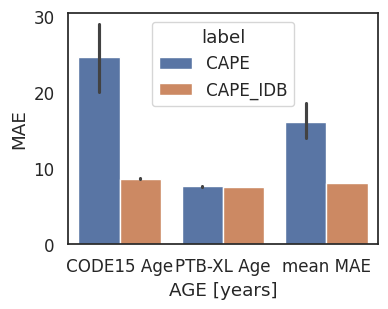

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
out_dir = os.path.join('results', 'Comparing_CAPE_IDB')
u.safe_mkdir(out_dir)
new_bidmc =pd.melt(combined, id_vars='label', var_name='AGE [years]', value_name='AUC/MAE').dropna()
sns.set(font_scale=1.1)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(4, 3))
sns.barplot(new_bidmc,  x= 'AGE [years]', y = 'AUC/MAE', 
            order= ['CODE15 Age', 'PTB-XL Age', 'mean MAE'], 
            hue='label', width=0.8, 
            #hue_order = ['bidmc', 'code', 'shanghai', 'ptb', 'ukb'] 
            )
plt.ylabel('MAE')
#plt.ylim(0.5, 1.05)
plt.savefig(os.path.join(out_dir, 'bar_age.pdf'))

**Sex AUC**

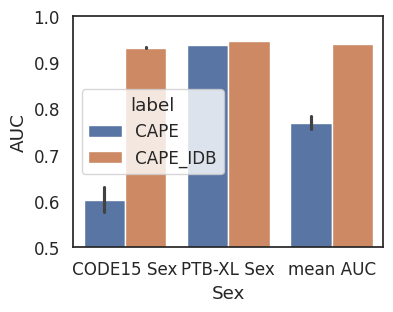

In [31]:
out_dir = os.path.join('results', 'Comparing_CAPE_IDB')
u.safe_mkdir(out_dir)
new_bidmc =pd.melt(combined, id_vars='label', var_name='Sex', value_name='AUC/MAE').dropna()
sns.set(font_scale=1.1)
sns.set_style(style='white')
fig, ax = plt.subplots(figsize=(4, 3))
sns.barplot(new_bidmc,  x= 'Sex', y = 'AUC/MAE', 
            order= ['CODE15 Sex', 'PTB-XL Sex', 'mean AUC'], 
            hue='label', width=0.8, 
            #hue_order = ['bidmc', 'code', 'shanghai', 'ptb', 'ukb'] 
            )
plt.ylabel('AUC')
plt.ylim(0.5, 1.0)
plt.savefig(os.path.join(out_dir, 'bar_sex.pdf'))

# Plotting age distributions for 10k samples

In [34]:
label = 'age'
y1, y_pred1 = test1.get_pred(label=label) 
y2, y_pred2 = test2.get_pred(label=label) 

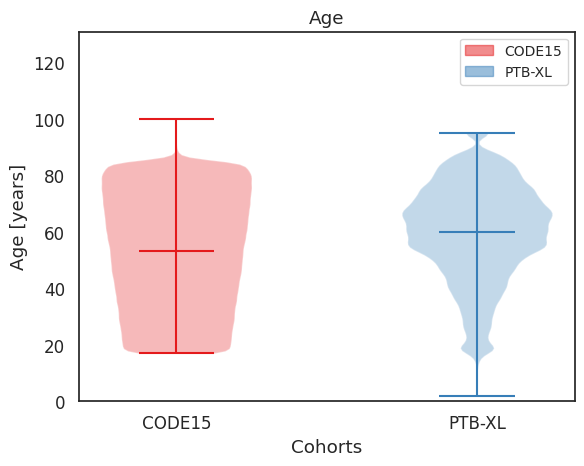

In [37]:
import matplotlib.patches as mpatches
datasets = ['CODE15', 'PTB-XL']
colors = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00']
plt.rcParams.update({'font.size': 14})
age_list = y1
    
plots = plt.violinplot(age_list, showmeans=True)
labels = []
datasets_upper =[]
for pc, color, dataset in zip(plots['bodies'], colors, datasets):
    #dataset = dataset.upper()
    #datasets_upper.append(dataset)
    pc.set_facecolor(color)
    labels.append(mpatches.Patch(color=color, label=dataset, alpha=0.5))
plt.legend(handles=labels, fontsize=10)
# Set the color of the median lines
plots['cmeans'].set_colors(colors)
plots['cbars'].set_colors(colors)
plots['cmins'].set_colors(colors)
plots['cmaxes'].set_colors(colors)
plt.xlabel('Cohorts')
plt.ylabel('Age [years]')
plt.xticks(np.arange(len(datasets))+1, datasets)
plt.ylim(0, 131)
plt.title('Age')
#plt.legend()
plt.savefig(os.path.join(out_dir, f'{dataset}_age.pdf'))

# Plotting age MAE distributions for 10k samples for CAPE test1 (run1)

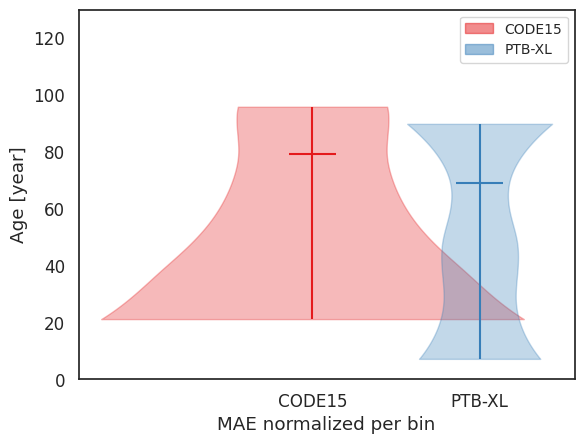

In [41]:
import math
from scipy.interpolate import make_interp_spline
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 14})
offset=0
xticks = []
nbins=30
agebins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 120]
wbins = 10
colors = ['#e41a1c', '#377eb8']#, '#4daf4a', '#984ea3', '#ff7f00']
labels = []
for i, dataset in enumerate(datasets):       
    mae_age = np.absolute(y1[i] - y_pred1[i])
    nbins = int(math.ceil((y1[i].max() - y_pred1[i].min())/wbins))
    values, bins =  np.histogram(y1[i], weights = mae_age, bins=nbins) 
    counts, _ =  np.histogram(y1[i], bins=bins)
    valid = counts>0
    counts = counts[valid]
    values = values[valid]
    n_values = values/counts
    bin_centers = (bins[:-1] + bins[1:]) / 2

    x_left = -n_values
    x_right = n_values
    offset = offset + np.amax(n_values)+20
    min_pt = bin_centers[np.argmin(n_values)]
    if i==0: bidmc_min = min_pt
    xticks.append(offset)
    plt.vlines(offset, bin_centers.min(), bin_centers.max(), color=colors[i])
    plt.hlines(min_pt, offset-5, offset+5, color=colors[i])
    # Smooth the curve using interpolation
    spline = make_interp_spline(bin_centers, x_left, k=3)
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 200)
    y_smooth_left = spline(x_smooth)

    spline_right = make_interp_spline(bin_centers, x_right, k=3)
    y_smooth_right = spline_right(x_smooth)
    y_smooth_left = np.array(y_smooth_left) + offset
    y_smooth_right = np.array(y_smooth_right) + offset
    # Plot
    labels.append(mpatches.Patch(color=colors[i], label=datasets[i], alpha=0.5))
    plt.fill_betweenx(x_smooth, y_smooth_left, y_smooth_right, color=colors[i], alpha=0.3)

plt.ylabel('Age [year]')
plt.xlabel('MAE normalized per bin')
plt.xticks(xticks, datasets)
plt.ylim(0, 130)
plt.legend(handles=labels, fontsize=10)
plt.savefig(os.path.join(out_dir, f'voilin_mae_age_CAPE.pdf'))


# Plotting age MAE distributions for 10k samples for CAPE-IDB test1 (run1)

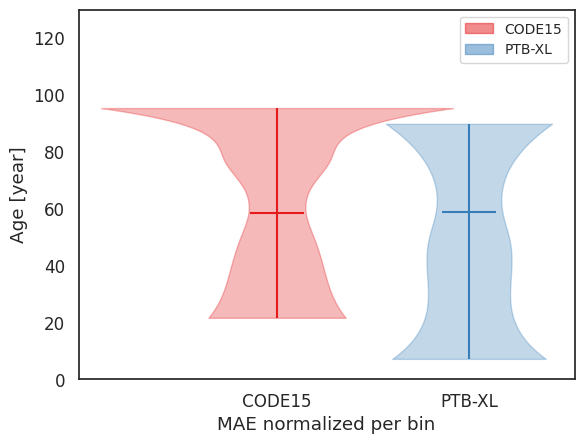

In [42]:
import math
from scipy.interpolate import make_interp_spline
import matplotlib.patches as mpatches
plt.rcParams.update({'font.size': 14})
offset=0
xticks = []
nbins=30
agebins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 120]
wbins = 10
colors = ['#e41a1c', '#377eb8']#, '#4daf4a', '#984ea3', '#ff7f00']
labels = []
for i, dataset in enumerate(datasets):       
    mae_age = np.absolute(y2[i] - y_pred2[i])
    nbins = int(math.ceil((y2[i].max() - y_pred2[i].min())/wbins))
    values, bins =  np.histogram(y2[i], weights = mae_age, bins=nbins) 
    counts, _ =  np.histogram(y2[i], bins=bins)
    valid = counts>0
    counts = counts[valid]
    values = values[valid]
    n_values = values/counts
    bin_centers = (bins[:-1] + bins[1:]) / 2

    x_left = -n_values
    x_right = n_values
    offset = offset + np.amax(n_values)+20
    min_pt = bin_centers[np.argmin(n_values)]
    if i==0: bidmc_min = min_pt
    xticks.append(offset)
    plt.vlines(offset, bin_centers.min(), bin_centers.max(), color=colors[i])
    plt.hlines(min_pt, offset-5, offset+5, color=colors[i])
    # Smooth the curve using interpolation
    spline = make_interp_spline(bin_centers, x_left, k=3)
    x_smooth = np.linspace(bin_centers.min(), bin_centers.max(), 200)
    y_smooth_left = spline(x_smooth)

    spline_right = make_interp_spline(bin_centers, x_right, k=3)
    y_smooth_right = spline_right(x_smooth)
    y_smooth_left = np.array(y_smooth_left) + offset
    y_smooth_right = np.array(y_smooth_right) + offset
    # Plot
    labels.append(mpatches.Patch(color=colors[i], label=datasets[i], alpha=0.5))
    plt.fill_betweenx(x_smooth, y_smooth_left, y_smooth_right, color=colors[i], alpha=0.3)
    
plt.ylabel('Age [year]')
plt.xlabel('MAE normalized per bin')
plt.xticks(xticks, datasets)
plt.ylim(0, 130)
plt.legend(handles=labels, fontsize=10)
plt.savefig(os.path.join(out_dir, f'voilin_mae_age_CAPE_IDB.pdf'))
